### Carregando libs

In [58]:
!pip install openpyxl

import pandas as pd
import matplotlib.pyplot as plt

### 1. Carregamento & Preparação do Dataset

In [59]:
df = pd.read_excel("datasets/coffee_sales.xlsx")

# Criando nova coluna
df["total_revenue"] = df["transaction_qty"] * df["unit_price"]
df.head()

# Transformando data para tipo BR
df['transaction_date'] = pd.to_datetime(
    df['transaction_date'],
    errors='coerce',
    dayfirst=True,            
    infer_datetime_format=True
)

/tmp/ipykernel_6090/11551075.py:8: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['transaction_date'] = pd.to_datetime(


In [60]:
df.count()

transaction_id      149116
transaction_date    149116
transaction_time    149116
transaction_qty     149116
store_id            149116
store_location      149116
product_id          149116
unit_price          149116
product_category    149116
product_type        149116
product_detail      149116
total_revenue       149116
dtype: int64

### Listando produtos

In [61]:
produtos = df["product_detail"].unique().tolist()
for i, produto in enumerate(produtos):
    print(f"{i+1}. {produto}")


1. Ethiopia Rg
2. Spicy Eye Opener Chai Lg
3. Dark chocolate Lg
4. Our Old Time Diner Blend Sm
5. Oatmeal Scone
6. Columbian Medium Roast Sm
7. Latte Rg
8. Dark chocolate Rg
9. Spicy Eye Opener Chai Rg
10. Ethiopia Lg
11. Earl Grey Lg
12. Ouro Brasileiro shot
13. Serenity Green Tea Lg
14. Jumbo Savory Scone
15. Lemon Grass Rg
16. Sustainably Grown Organic Lg
17. Hazelnut Biscotti
18. Cappuccino
19. Lemon Grass Lg
20. Chocolate Chip Biscotti
21. Peppermint Lg
22. Chocolate Croissant
23. Latte
24. Brazilian Rg
25. Brazilian Lg
26. Columbian Medium Roast Rg
27. Morning Sunrise Chai Rg
28. Morning Sunrise Chai Lg
29. Our Old Time Diner Blend Lg
30. Sustainably Grown Organic Rg
31. Scottish Cream Scone 
32. Peppermint Rg
33. English Breakfast Rg
34. Our Old Time Diner Blend Rg
35. Serenity Green Tea Rg
36. Brazilian Sm
37. Jamaican Coffee River Sm
38. Jamaican Coffee River Lg
39. Ginger Biscotti
40. Traditional Blend Chai Lg
41. Cappuccino Lg
42. Espresso shot
43. Earl Grey Rg
44. Ginger Sc

### Listando lojas

In [62]:
lojas = df["store_location"].unique()
print(lojas)

['Lower Manhattan' "Hell's Kitchen" 'Astoria']


## 2. Funções Utilitárias

In [63]:
def fmt_currency(x, pos):
    return f"${x:,.0f}"


# Criando novo dataset para listar 5 produtos
df_clean = df.copy()

# Garantir datetime
df_clean["transaction_date"] = pd.to_datetime(df_clean["transaction_date"])

# Criar coluna de receita
df_clean["sales"] = df_clean["transaction_qty"] * df_clean["unit_price"]

# Criar coluna Year-Month (período mensal)
df_clean["year_month"] = df_clean["transaction_date"].dt.to_period("M").dt.to_timestamp()


# 5 melhores produtos
top5_products = (
    df_clean.groupby("product_detail", as_index=False)["sales"]
    .sum()
    .sort_values("sales", ascending=False)
    .head(5)
)

currency_fmt = mtick.FuncFormatter(fmt_currency)

# Comparativo de vendas por mês
monthly_sales = (
    df_clean.groupby("year_month", as_index=False)["sales"]
    .sum()
    .sort_values("year_month")
)

# Melhor loja por mês
monthly_store_sales = (
    df_clean.groupby(["year_month", "store_location"], as_index=False)["sales"]
    .sum()
)
best_store_per_month = (
    monthly_store_sales.sort_values(["year_month", "sales"], ascending=[True, False])
    .groupby("year_month", as_index=False)
    .first()
)

# Melhor produto de cada loja
produto_loja = (
    df_clean.groupby(["store_location", "product_detail"], as_index=False)["sales"]
    .sum()
)
melhor_produto_loja = (
    produto_loja.sort_values(["store_location", "sales"], ascending=[True, False])
    .groupby("store_location", as_index=False)
    .first()
)

# Participação das lojas na receita acumulada
METRIC = "sales"

loja_total = (
    df_clean.groupby("store_location")[METRIC]
      .sum()
      .sort_values(ascending=False)
      .reset_index()
)


### 5 melhores produtos

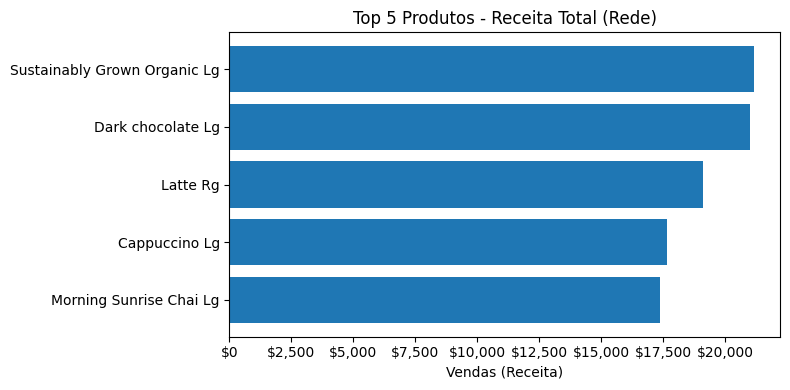

In [64]:
fig, ax = plt.subplots(figsize=(8, 4))
top5_products_sorted = top5_products.sort_values("sales")  
ax.barh(top5_products_sorted["product_detail"], top5_products_sorted["sales"])
ax.set_xlabel("Vendas (Receita)")
ax.set_title("Top 5 Produtos - Receita Total (Rede)")
ax.xaxis.set_major_formatter(currency_fmt)
plt.tight_layout()
plt.show()  

### Comparativo de vendas por mês (total rede)

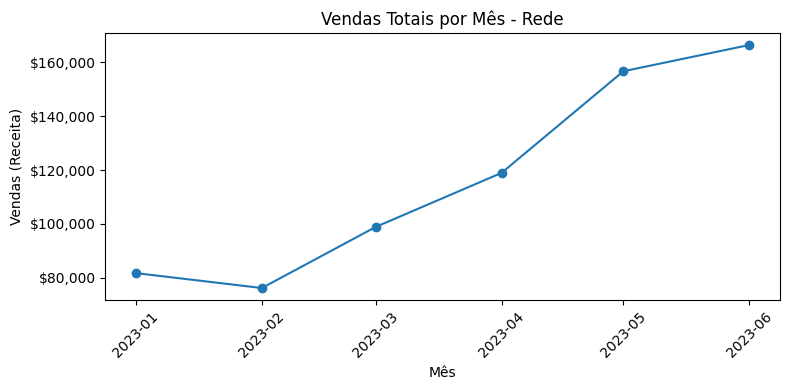

In [65]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(monthly_sales["year_month"], monthly_sales["sales"], marker="o")
ax.set_ylabel("Vendas (Receita)")
ax.set_title("Vendas Totais por Mês - Rede")
ax.yaxis.set_major_formatter(currency_fmt)
ax.set_xlabel("Mês")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Melhor loja por mês (maior receita no mês)

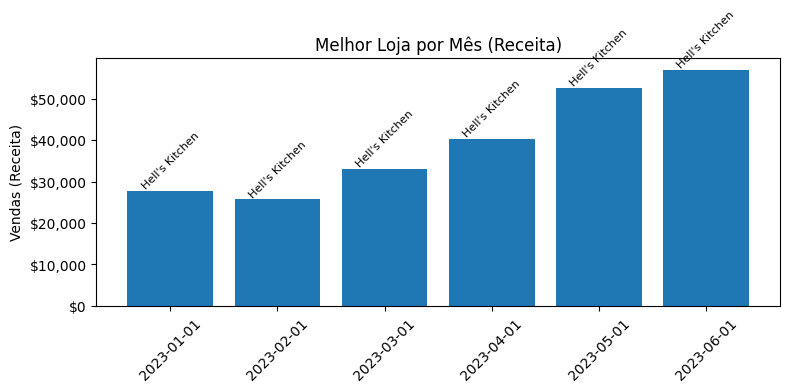

In [66]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(best_store_per_month["year_month"].astype(str), best_store_per_month["sales"])
ax.set_ylabel("Vendas (Receita)")
ax.set_title("Melhor Loja por Mês (Receita)")
ax.yaxis.set_major_formatter(currency_fmt)
plt.xticks(rotation=45)
for i, (month, store, val) in best_store_per_month.iterrows():
    ax.text(i, val, store, ha="center", va="bottom", rotation=45, fontsize=8)
plt.tight_layout()
plt.show()

### Melhor produto de cada loja (tudo acumulado)

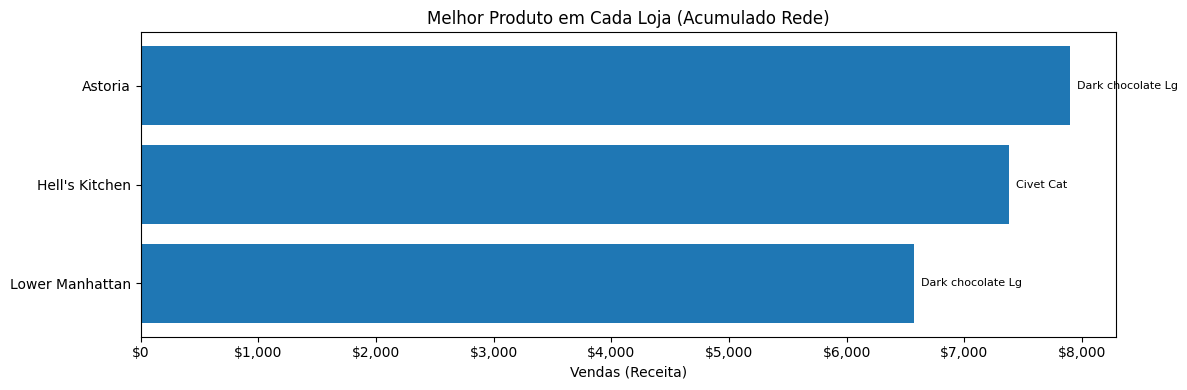

In [67]:
fig, ax = plt.subplots(figsize=(12, 4))
bp_sorted = melhor_produto_loja.sort_values("sales")
ax.barh(bp_sorted["store_location"], bp_sorted["sales"])
ax.set_xlabel("Vendas (Receita)")
ax.set_title("Melhor Produto em Cada Loja (Acumulado Rede)")
ax.xaxis.set_major_formatter(currency_fmt)

for y, (store, product, val) in enumerate(bp_sorted.values):
    ax.text(val, y, f"  {product}", va="center", ha="left", fontsize=8)
plt.tight_layout()
plt.show()

### Participação das lojas na receita acumulada

Text(0.5, 1.0, 'Participação das Lojas na Receita Acumulada')

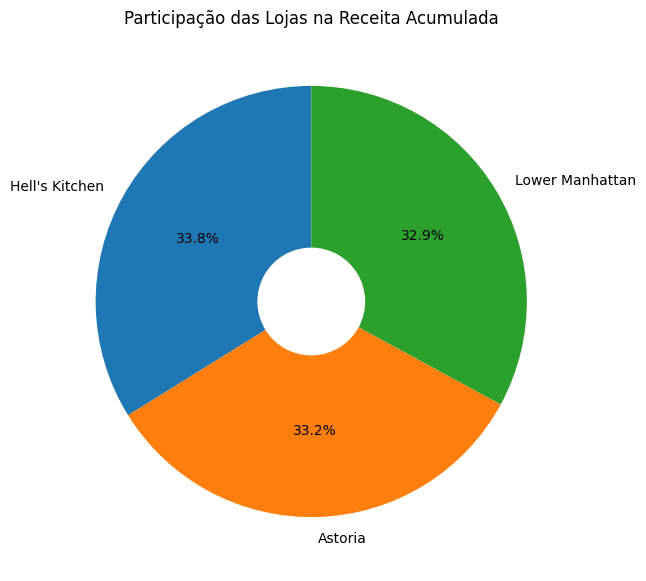

In [68]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.pie(
    loja_total[METRIC],
    labels=loja_total["store_location"],
    autopct="%1.1f%%",         
    startangle=90,
    wedgeprops={"width": 0.75}   
)

ax.set_title("Participação das Lojas na Receita Acumulada")